In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
dataframe = pd.read_csv("dataset_with_missing_values_duplicates_removed.csv")
print(f"Dataset shape after cleaning: {dataframe.shape}")

Dataset shape after cleaning: (2035, 12)


In [6]:
dataframe.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [3]:
# calculate the counts of real and fake news from each news source
fake_true_news_counts_for_each_news_source = dataframe.groupby(["site_url", "label"]).size().unstack(fill_value=0)

In [4]:
# Caluclate the percentage of fake news and real news for each news source
fake_true_news_counts_for_each_news_source["Real News Publication Percentage (%)"] = (fake_true_news_counts_for_each_news_source["Real"] / (fake_true_news_counts_for_each_news_source["Real"] + fake_true_news_counts_for_each_news_source["Fake"])) * 100
fake_true_news_counts_for_each_news_source["Fake News Publication Percentage (%)"] = (fake_true_news_counts_for_each_news_source["Fake"] / (fake_true_news_counts_for_each_news_source["Real"] + fake_true_news_counts_for_each_news_source["Fake"])) * 100

In [5]:
# Calculate total articles for each source for better analysis
# This helps in assessing the statistical significance of the credibility score
fake_true_news_counts_for_each_news_source["Total Articles"] = fake_true_news_counts_for_each_news_source["Real"] + fake_true_news_counts_for_each_news_source["Fake"]

In [6]:
# Sort by credibility (real news percentage)
sorted_news_sources = fake_true_news_counts_for_each_news_source.sort_values(by="Real News Publication Percentage (%)", ascending=False)

In [7]:
sorted_news_sources.head()

label,Fake,Real,Real News Publication Percentage (%),Fake News Publication Percentage (%),Total Articles
site_url,,,,,
100percentfedup.com,0,33,100.0,0.0,33
dailywire.com,0,81,100.0,0.0,81
whydontyoutrythis.com,0,2,100.0,0.0,2
redstatewatcher.com,0,1,100.0,0.0,1
proudemocrat.com,0,1,100.0,0.0,1


In [8]:
print("Top 10 Most Credible News Sources:")
for news_source, row in sorted_news_sources.head(10).iterrows():
    print(f"News Source: {news_source}, Real News Publication Percentage: {row['Real News Publication Percentage (%)']:.1f}%")


print("Top 10 Least Credible News Sources:")
for news_source, row in sorted_news_sources.tail(10).iterrows():
    print(f"News Source: {news_source}, Real News Publication Percentage: {row['Real News Publication Percentage (%)']:.1f}%")

Top 10 Most Credible News Sources:
News Source: 100percentfedup.com, Real News Publication Percentage: 100.0%
News Source: dailywire.com, Real News Publication Percentage: 100.0%
News Source: whydontyoutrythis.com, Real News Publication Percentage: 100.0%
News Source: redstatewatcher.com, Real News Publication Percentage: 100.0%
News Source: proudemocrat.com, Real News Publication Percentage: 100.0%
News Source: presstv.com, Real News Publication Percentage: 100.0%
News Source: politicususa.com, Real News Publication Percentage: 100.0%
News Source: wnd.com, Real News Publication Percentage: 100.0%
News Source: addictinginfo.org, Real News Publication Percentage: 100.0%
News Source: returnofkings.com, Real News Publication Percentage: 99.0%
Top 10 Least Credible News Sources:
News Source: defenddemocracy.press, Real News Publication Percentage: 0.0%
News Source: dennismichaellynch.com, Real News Publication Percentage: 0.0%
News Source: departed.co, Real News Publication Percentage: 0.0

In [9]:
# Create enhanced credibility score with volume weighting
# This implementation incorporats explicit source credibility scores and
# aggregating multiple credibility signals into a composite score
credibility_factors = sorted_news_sources.reset_index()[['site_url', 'Real News Publication Percentage (%)', 'Total Articles']]

# Add weight based on volume (more articles = more confident in the score)
# Log scale to prevent domination by very high volume news sources
# This approach creates a confidence factor based on the quantity of data available
# Similar to how organizations like NewsGuard and MBFC consider the accumulation
# of evidence when determining source credibility
# np.log1p(...) is the natural logarithm of (1 + x). It's used instead of np.log() to avoid log(0) and to handle small values better.
# log1p(x)=log(1+x)
# 'np.log1p(credibility_factors['Total Articles'].max())' finds the maximum article count among all news sources and applies the same log transform
credibility_factors['volume_weight'] = np.log1p(credibility_factors['Total Articles']) / np.log1p(credibility_factors['Total Articles'].max())

# Calculate final composite score (weighted average)
# 80% based on real news publication percentage, 20% based on volume confidence
# This implements the concept of aggregating credibility signals 
# by combining factuality measures with confidence measures into a single score
credibility_factors['source_credibility_score'] = (
   0.8 * credibility_factors['Real News Publication Percentage (%)'] +  # Base credibility is most important
   0.2 * (credibility_factors['volume_weight'] * 100)                   # Volume confidence (scaled to percentage)
)

# Sort by composite score
final_credibility = credibility_factors.sort_values('source_credibility_score', ascending=False)

print("\nTop news sources by enhanced news source credibility score:")
for i, (_, row) in enumerate(final_credibility.head(15).iterrows()):
   print(f"{i+1}. {row['site_url']} - Enhanced News Source Credibility Score: {row['source_credibility_score']:.1f}, " +
         f"Base Real News Publication Percentage Credibility: {row['Real News Publication Percentage (%)']:.1f}%, " +
         f"Total Number of Articles Publication: {row['Total Articles']}")





Top news sources by enhanced news source credibility score:
1. politicususa.com - Enhanced News Source Credibility Score: 100.0, Base Real News Publication Percentage Credibility: 100.0%, Total Number of Articles Publication: 100
2. presstv.ir - Enhanced News Source Credibility Score: 99.2, Base Real News Publication Percentage Credibility: 99.0%, Total Number of Articles Publication: 100
3. frontpagemag.com - Enhanced News Source Credibility Score: 99.2, Base Real News Publication Percentage Credibility: 99.0%, Total Number of Articles Publication: 100
4. returnofkings.com - Enhanced News Source Credibility Score: 99.2, Base Real News Publication Percentage Credibility: 99.0%, Total Number of Articles Publication: 100
5. dailywire.com - Enhanced News Source Credibility Score: 99.1, Base Real News Publication Percentage Credibility: 100.0%, Total Number of Articles Publication: 81
6. westernjournalism.com - Enhanced News Source Credibility Score: 98.4, Base Real News Publication Perce

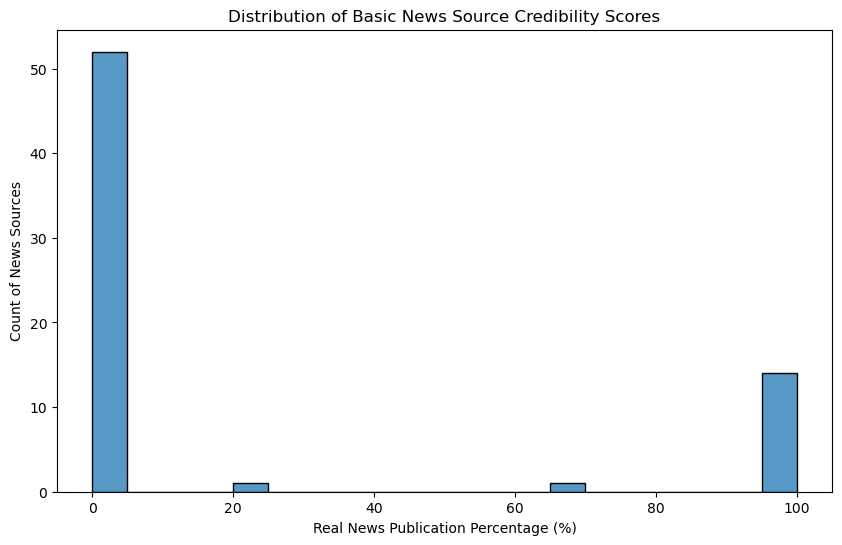

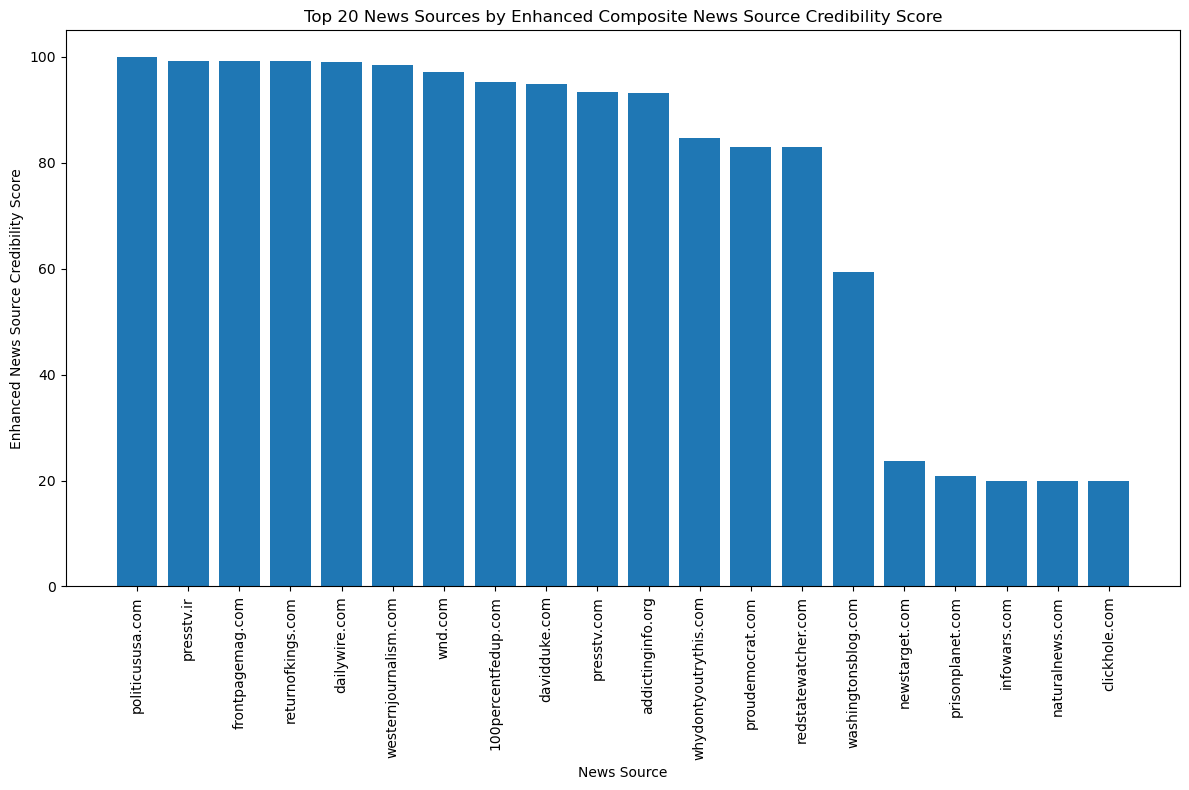

In [12]:
# Visualizations for better understanding
# Plot distribution of basic news source credibility scores
plt.figure(figsize=(10, 6))
sns.histplot(sorted_news_sources["Real News Publication Percentage (%)"], bins=20)
plt.title("Distribution of Basic News Source Credibility Scores")
plt.xlabel("Real News Publication Percentage (%)")
plt.ylabel("Count of News Sources")
plt.show()

# Plot enhanced composite credibility scores
plt.figure(figsize=(12, 8))
plt.bar(final_credibility['site_url'].head(20), final_credibility['source_credibility_score'].head(20))
plt.title("Top 20 News Sources by Enhanced Composite News Source Credibility Score")
plt.xlabel("News Source")
plt.ylabel("Enhanced News Source Credibility Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [13]:
# Author-based credibility analysis
# This approach extends the source credibility analysis to authors,
# treating each author as a potential signal for content reliability
print("\n--- Author-based Credibility Analysis ---")

# Get author distribution
author_counts = dataframe["author"].value_counts()
print(f"Total unique authors: {len(author_counts)}")
print(f"Top 10 authors by articles publication count:")
print(author_counts.head(10))


--- Author-based Credibility Analysis ---
Total unique authors: 485
Top 10 authors by articles publication count:
author
No Author                              505
Activist Post                           82
EdJenner                                73
noreply@blogger.com (Der Postillon)     72
Daniel Greenfield                       55
Anonymous                               48
admin                                   48
Jason Easley                            45
Alex Ansary                             44
Dr. Patrick Slattery                    38
Name: count, dtype: int64


In [18]:
# Calculate credibility scores for authors with multiple articles
# Similar to the source credibility approach, creating a historical accuracy profile for each author 
# (x == "Real") creates a Boolean Series, with True where the article is labeled "Real" and False otherwise.
# .mean() treats True as 1 and False as 0, so this gives the fraction of "Real" articles.
# * 100 converts the fraction to a percentage.
author_credibility = dataframe.groupby("author")["label"].apply(
   lambda x: (x == "Real").mean() * 100
).reset_index()
author_credibility.columns = ["author", "Real News Publication Percentage (%)"]


# For debugging, print column names
print("Column names in author_credibility before merge:")
print(author_credibility.columns.tolist())


Column names in author_credibility before merge:
['author', 'Real News Publication Percentage (%)']


In [19]:
# Prepare author_counts for merging
author_count_df = author_counts.reset_index()
author_count_df.columns = ["author", "Articles_Count"]  # Use underscore instead of space to be safe

print("Column names in author_count_df:")
print(author_count_df.columns.tolist())

Column names in author_count_df:
['author', 'Articles_Count']


In [20]:
# Add article count
author_credibility = author_credibility.merge(
   author_count_df,
   on="author"
)

# After merge, verify column names
print("Column names in author_credibility after merge:")
print(author_credibility.columns.tolist())

Column names in author_credibility after merge:
['author', 'Real News Publication Percentage (%)', 'Articles_Count']


In [21]:
# Add volume weight using the same approach as sources
author_credibility['volume_weight'] = np.log1p(author_credibility['Articles_Count']) / np.log1p(author_credibility['Articles_Count'].max())

# Calculate composite score for authors
# Applying the same weighted aggregation of signals as with news sources,
# aligning with Section V.D's framework for combining credibility signals
author_credibility['enhanced_author_credibility_score'] = (
   0.8 * author_credibility['Real News Publication Percentage (%)'] +
   0.2 * (author_credibility['volume_weight'] * 100)
)

# Sort by author credibility score
author_credibility = author_credibility.sort_values("enhanced_author_credibility_score", ascending=False)

print("\nTop authors by enhanced author credibility score:")
print(author_credibility.head(10))


Top authors by enhanced author credibility score:
                   author  Real News Publication Percentage (%)  \
120              EdJenner                            100.000000   
186          Jason Easley                            100.000000   
1             -NO AUTHOR-                            100.000000   
85      Daniel Greenfield                             96.363636   
357           Sarah Jones                            100.000000   
159  Hrafnkell Haraldsson                            100.000000   
349       Roosh Valizadeh                            100.000000   
130                Fed Up                            100.000000   
362        Sean Colarossi                            100.000000   
117  Dr. Patrick Slattery                             94.736842   

     Articles_Count  volume_weight  enhanced_author_credibility_score  
120              73       0.691245                          93.824909  
186              45       0.614891                          92.2978

In [22]:
# Add source credibility score to the original dataframe
# Create a mapping dictionary from site_url to source_credibility_score
source_credibility_mapping = final_credibility[['site_url', 'source_credibility_score']].set_index('site_url').to_dict()['source_credibility_score']

# Add the credibility score to each article in the original dataframe
dataframe['enhanced_source_credibility_score'] = dataframe['site_url'].map(source_credibility_mapping)

# Create a mapping dictionary from author to author_credibility_score
author_credibility_mapping = author_credibility[['author', 'enhanced_author_credibility_score']].set_index('author').to_dict()['enhanced_author_credibility_score']

# Add the author credibility score to each article in the original dataframe
dataframe['enhanced_author_credibility_score'] = dataframe['author'].map(author_credibility_mapping)

# Display the updated dataframe with enhanced source and author credibility scores
print("\nDataframe with added enhanced news source and author credibility scores:")
print(dataframe[['author', 'site_url', 'label', 'enhanced_source_credibility_score', 'enhanced_author_credibility_score']].head())

# Save the updated dataframe with the new credibility score attributes
dataframe.to_csv('cleaned_dataset_with_enhanced_news_source_and_author_credibility_scores.csv', index=False)


Dataframe with added enhanced news source and author credibility scores:
                 author             site_url label  \
0     Barracuda Brigade  100percentfedup.com  Real   
1  reasoning with facts  100percentfedup.com  Real   
2     Barracuda Brigade  100percentfedup.com  Real   
3                Fed Up  100percentfedup.com  Real   
4                Fed Up  100percentfedup.com  Real   

   enhanced_source_credibility_score  enhanced_author_credibility_score  
0                           95.28177                          85.755236  
1                           95.28177                          82.226429  
2                           95.28177                          85.755236  
3                           95.28177                          88.238767  
4                           95.28177                          88.238767  


In [ ]:
# Add volume weight using the same approach as sources
author_credibility['volume_weight'] = np.log1p(author_credibility['Articles_Count']) / np.log1p(author_credibility['Articles_Count'].max())

# Calculate composite score for authors
# Applying the same weighted aggregation of signals as with news sources,
# aligning with Section V.D's framework for combining credibility signals
author_credibility['enhanced_author_credibility_score'] = (
   0.8 * author_credibility['Real News Publication Percentage (%)'] +
   0.2 * (author_credibility['volume_weight'] * 100)
)

# Sort by author credibility score
author_credibility = author_credibility.sort_values("enhanced_author_credibility_score", ascending=False)

print("\nTop authors by enhanced author credibility score:")
print(author_credibility.head(10))


Top authors by enhanced author credibility score:
                   author  Real News Publication Percentage (%)  \
120              EdJenner                            100.000000   
186          Jason Easley                            100.000000   
1             -NO AUTHOR-                            100.000000   
85      Daniel Greenfield                             96.363636   
357           Sarah Jones                            100.000000   
159  Hrafnkell Haraldsson                            100.000000   
349       Roosh Valizadeh                            100.000000   
130                Fed Up                            100.000000   
362        Sean Colarossi                            100.000000   
117  Dr. Patrick Slattery                             94.736842   

     Articles_Count  volume_weight  enhanced_author_credibility_score  
120              73       0.691245                          93.824909  
186              45       0.614891                          92.2978